# Milestone 3&4 - Independent Project

## Author - Aeden Jameson



## Instructions

**Milestone 3** is where everything you built in the previous milestones comes together. For this Milestone, you focus on improving model accuracy and summarizing your findings. Try explaining your findings as if you are presenting to your management team in layman’s terms. For example, talk about the influencing factors, what can be improved, what is important in your findings, what is the key aspect to focus on, what do the data tell them that they do not know.

**For Milestone 4 you should**:

* update Milestones 1 and 2, based on feedback, and then
* prepare the data via cleaning, normalization, encoding categorical variables, et cetera;
* generate and evaluate a working linear model;
* enhance your model results by trying different model and/or data enhancement techniques, building 3 models with different regularization and 
* feature engineering techniques;
* evaluate your models using multiple performance metrics and explain your choice of model;
* draw direct inferences and conclusions from model results (describe how your model results can improve or provide a solution to the problem you have chosen);
* use graphs and evidence from the data to prove your conclusions in a form that tells a story that helps the a non-technical person in the business.

# Problem

Home buyers would like to understand the factors that most impact price for both purchasing and possibly upgrading their homes.


## Summary of Results

The last model explains ~82.5% of the variability of home prices. The best performing model considered sqft_living, grade, zipcode, condition and yr_built. 


## Step 1: Explore the dataset supported by charts and summary statistics

Here's a data dictionary for reference

* **id**   - Unique ID for each home sold 
* **date** - Date of the home sale 
* **price** - Price of each home sold 
* **bedrooms** - Number of bedrooms 
* **bathrooms** - Number of bathrooms, where .5 accounts for a room with a toilet but no shower 
* **sqft_living** - Square footage of the apartments interior living space 
* **sqft_lot** - Square footage of the land space 
* **floors** - Number of floors 
* **waterfront** - A dummy variable for whether the apartment was overlooking the waterfront or not 
* **view** - An index from 0 to 4 of how good the view of the property was 
* **condition** - An index from 1 to 5 on the condition of the apartment, 
* **grade** - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design. 
* **sqft_above** - The square footage of the interior housing space that is above ground level 
* **sqft_basement** - The square footage of the interior housing space that is below ground level 
* **yr_built** - The year the house was initially built 
* **yr_renovated** - The year of the house’s last renovation 
* **zipcode** - What zipcode area the house is in 
* **lat** - Lattitude 
* **long** - Longitude 
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors 
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors 

#### Load & Prepare Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import scatter_matrix
import scipy.stats as ss



def prepare(fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv"):
    data = pd.read_csv(fileName)

    # fix data types
    data['date'] = pd.to_datetime(data['date'])

    # Additional variables worth exploring    
    data['month_sold'] = data['date'].dt.month
    data['day_of_week'] = data['date'].dt.dayofweek
    data['year'] = data['date'].dt.year
    data['price_per_sqft'] = data['price'] / data['sqft_living']
    data['yr_old'] = data['year'] - np.maximum(data['yr_built'], data['yr_renovated'])


    # 20699 of the 21613 rows don't have a value so we'll drop this column
    data.drop('yr_renovated', axis = 1, inplace = True)

    # we don't need this for anything
    data.drop('id', axis = 1, inplace = True)
    
    to_drop = data.loc[(data['bedrooms'] > 7) | 
                       (data['bedrooms'] == 0) |
                       (data['bathrooms'] > 5) | 
                       (data['bathrooms'] < 1) | 
                       (data['sqft_lot'] > 300000) | 
                       (data['price'] > 1000000) | 
                       (data['price'] < 100000) | 
                       (data['grade'] < 5) |
                       (data['grade'] == 12)].index
    data.drop(to_drop, inplace = True)
    
    return data

housing = prepare()

First, lets get a feel for the types, sizes and summary statistics of the data we are dealing with so we can understand what kinds of visualizations might be helpful for uncovering relationships.

In [2]:
housing.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19940 entries, 0 to 21611
Data columns (total 24 columns):
date              19940 non-null datetime64[ns]
price             19940 non-null float64
bedrooms          19940 non-null int64
bathrooms         19940 non-null float64
sqft_living       19940 non-null int64
sqft_lot          19940 non-null int64
floors            19940 non-null float64
waterfront        19940 non-null int64
view              19940 non-null int64
condition         19940 non-null int64
grade             19940 non-null int64
sqft_above        19940 non-null int64
sqft_basement     19940 non-null int64
yr_built          19940 non-null int64
zipcode           19940 non-null int64
lat               19940 non-null float64
long              19940 non-null float64
sqft_living15     19940 non-null int64
sqft_lot15        19940 non-null int64
month_sold        19940 non-null int64
day_of_week       19940 non-null int64
year              19940 non-null int64
price_per_sqft

In [3]:
cols_for_stats = ['price', 'price_per_sqft','bedrooms','bathrooms','sqft_living','sqft_lot','floors','view','condition','grade','sqft_above','sqft_basement','sqft_living15']
housing[cols_for_stats].describe()

,price,price_per_sqft,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,sqft_living15
count,19940.000000,19940.000000,19940.000000,19940.000000,19940.000000,19940.000000,19940.000000,19940.000000,19940.000000,19940.000000,19940.000000,19940.000000,19940.000000
mean,468435.925125,252.762422,3.323821,2.042402,1957.161886,12993.725176,1.472693,0.159178,3.405617,7.514644,1694.019007,263.142879,1910.210832
std,195591.361299,99.013657,0.862597,0.692768,747.249706,25910.261698,0.536888,0.613340,0.643920,0.997784,706.508089,403.125225,600.254089
min,100000.000000,87.588235,1.000000,1.000000,390.000000,520.000000,1.000000,0.000000,1.000000,5.000000,390.000000,0.000000,399.000000
25%,315000.000000,178.333333,3.000000,1.500000,1400.000000,5000.000000,1.000000,0.000000,3.000000,7.000000,1170.000000,0.000000,1470.000000
50%,435000.000000,236.609582,3.000000,2.000000,1840.000000,7500.000000,1.000000,0.000000,3.000000,7.000000,1510.000000,0.000000,1800.000000
75%,594000.000000,303.576775,4.000000,2.500000,2410.000000,10202.000000,2.000000,0.000000,4.000000,8.000000,2080.000000,500.000000,2260.000000
max,1000000.000000,810.138889,7.000000,5.000000,6050.000000,295772.000000,3.500000,4.000000,5.000000,11.000000,5710.000000,2720.000000,4950.000000


## Graphically Explore Variables

We'll start off identifying potential relationships amongst our numerical variables with Pearson's Correlation displayed as a heatmap.

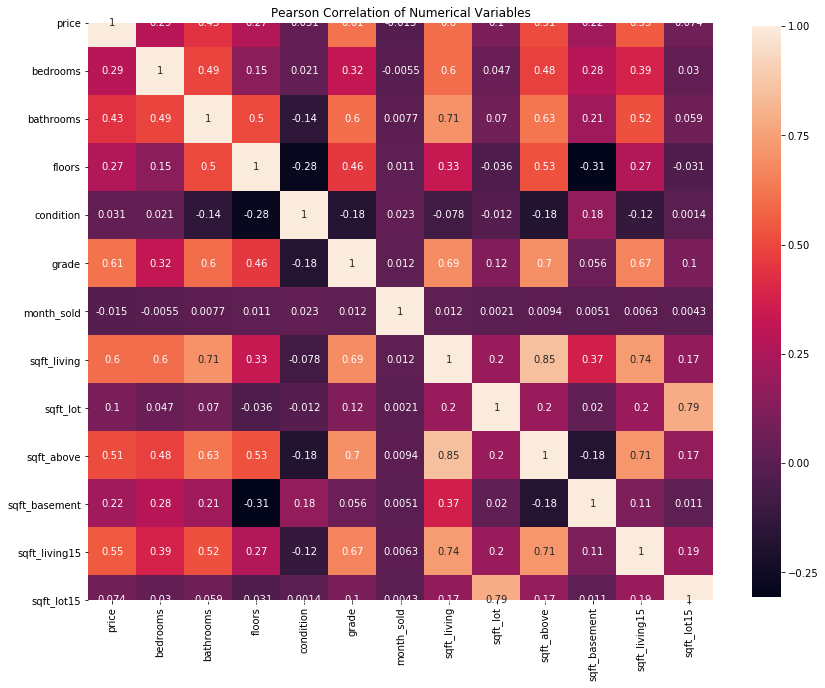

In [4]:
correlation_cols = ['price','bedrooms','bathrooms','floors','condition','grade','month_sold','sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
_,ax=plt.subplots(figsize=(14,14))
plt.title('Pearson Correlation of Numerical Variables')
sns.heatmap(housing[correlation_cols].corr(),vmax=1.0,annot=True,square=True, cbar_kws={"shrink": .75});

**Observation**: We can see there are several variables moderately correlated with price that can serve as starting points for our data analysis: sqft_living, sqft_above, sqft_living15. 

#### Distributional Observations

Next examine the distributional properties of our numerical variables with histograms.

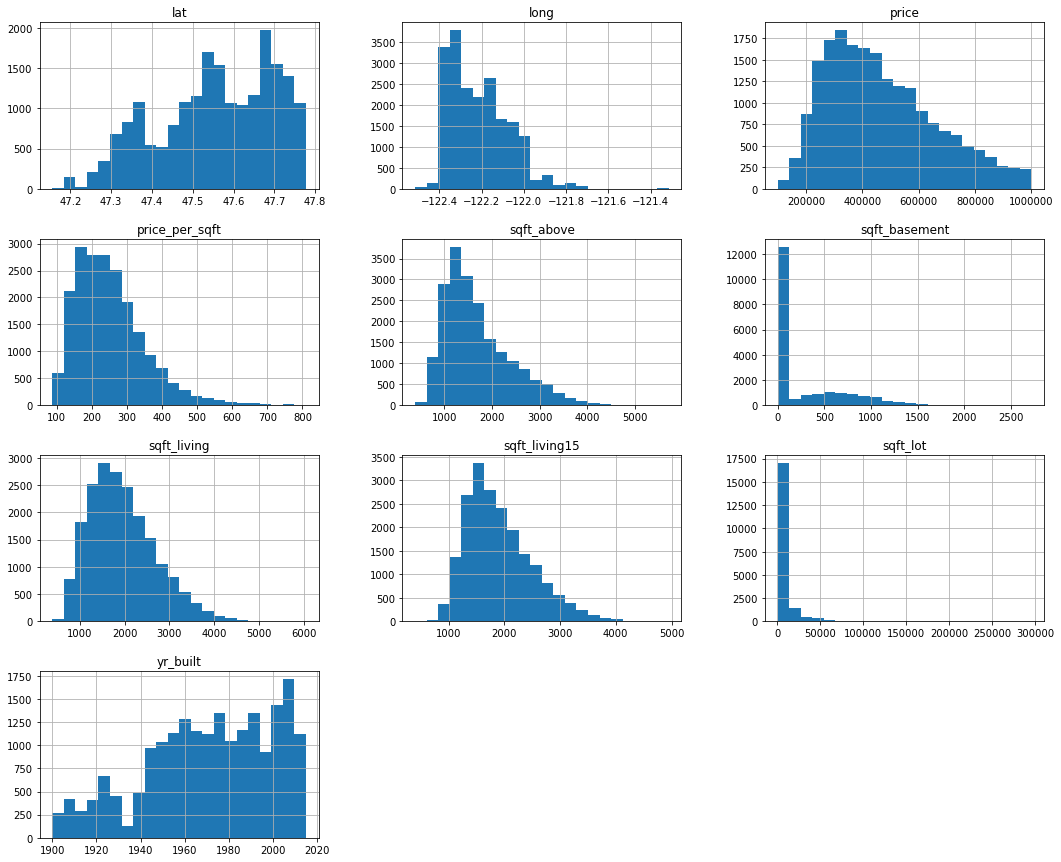

In [5]:

columns_for_hist = ['price','price_per_sqft','sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','yr_built', 'lat', 'long']
housing[columns_for_hist].hist(bins=22, figsize=(18, 15), layout=(4,3));

And now we'll examine categorical variables with bar plots.

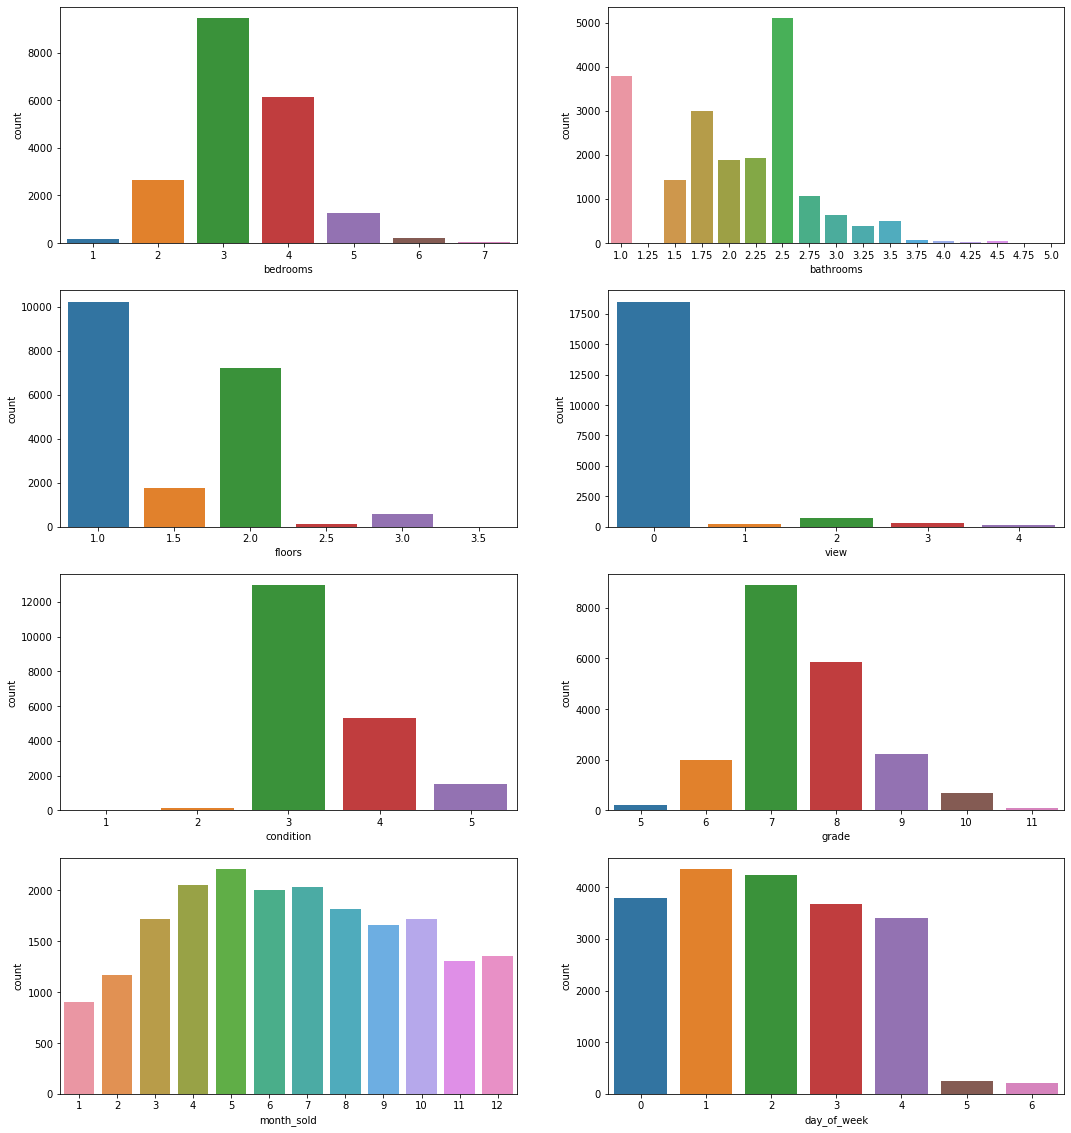

In [6]:
cols_for_barplots = ['bedrooms','bathrooms','floors','view','condition','grade','month_sold','day_of_week']
fig, ax = plt.subplots(4, 2, squeeze=True, figsize=(18, 20))
for col, subplot in zip(cols_for_barplots, ax.flatten()):
    sns.countplot(x=col, data=housing, ax=subplot)


***Observations***

* Most houses are in reasonble condition and grade. 
* Peak selling season was around April, May, June and July
* The sale price, sqft_above, sqft_lot, sqft_living, sqft_living15 all skew right
* The lat and long histograms are multi-modal, which suggests, unsurprisingly, that there are a concentration
  of houses in certain neighborhood.
* Since the 70's housing construction has slowly increased and there has been various boom years since as well.
* sqft_basement, sqft_lot, sqft_lot15 skew left extremely hard, which suggests there is a large number bigger
  lots of all different sizes.
* Most homes, not surprisingly, don't have a good view.

#### Relationships

Now let's take an even closer look at potential relationships between price and our categorical variables using box plots.

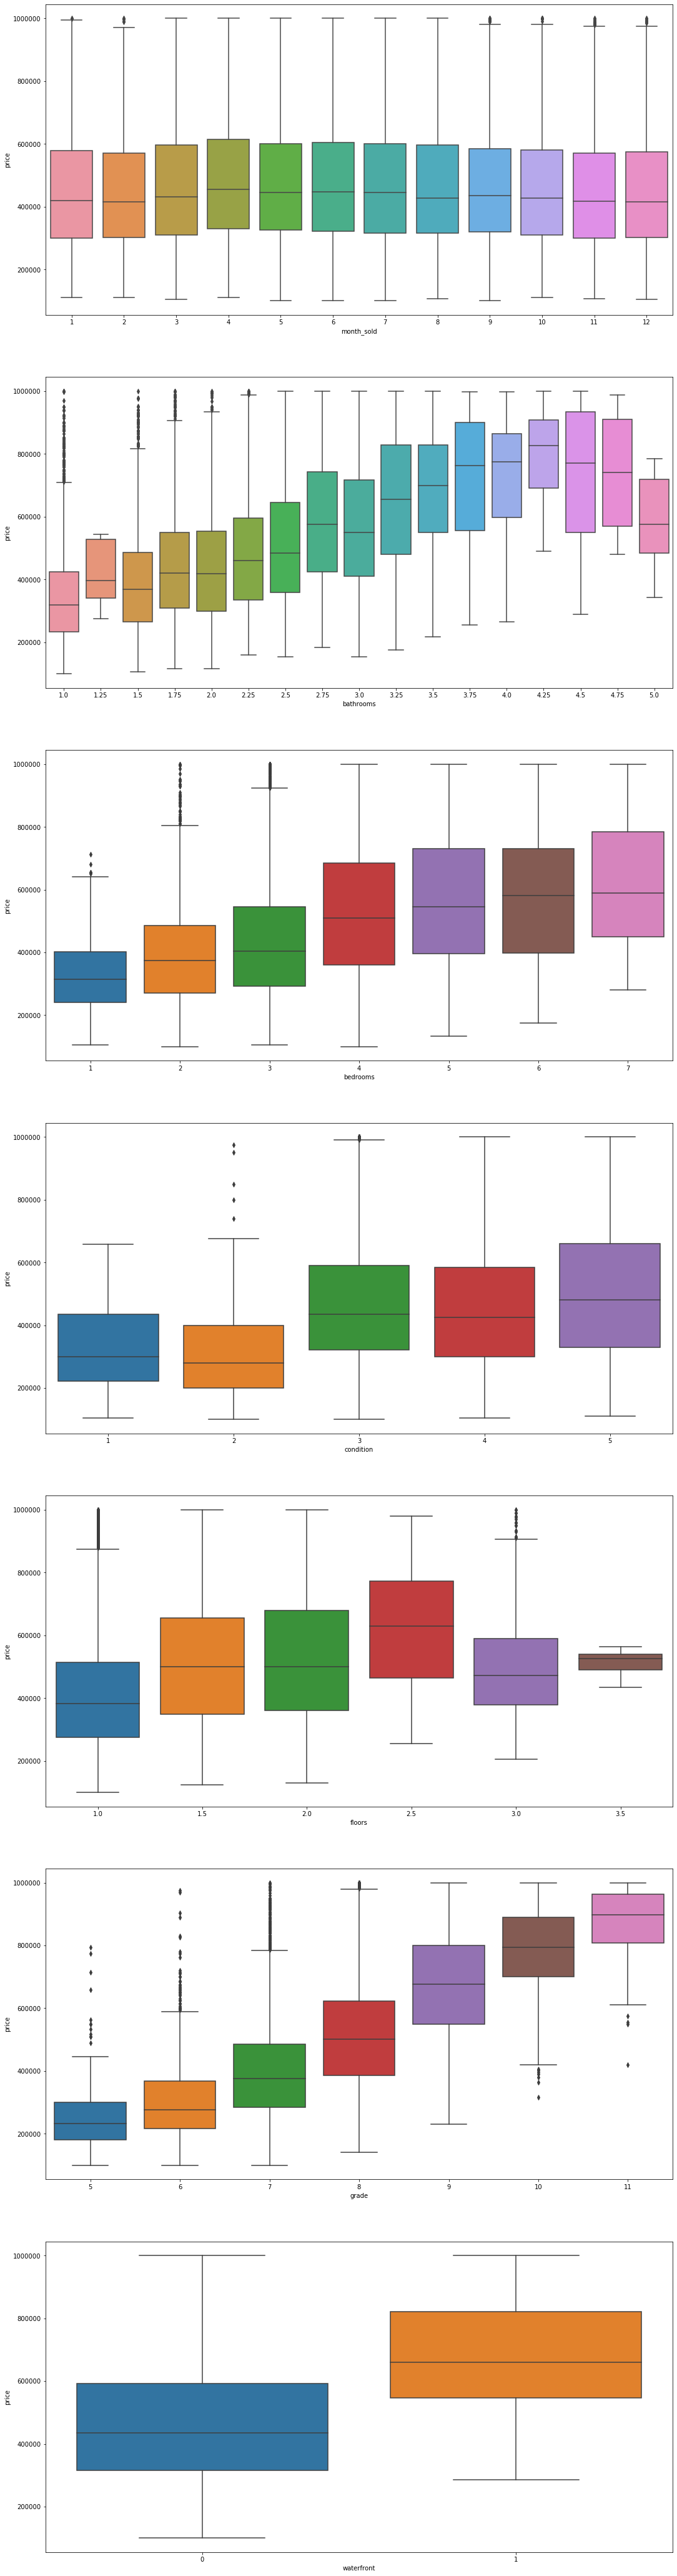

In [7]:
boxplot_fields = ['month_sold','bathrooms','bedrooms','condition','floors','grade','waterfront']
fig, ax = plt.subplots(7, 1, figsize=(18, 75))
for var, subplot in zip(boxplot_fields, ax.flatten()):
    sns.boxplot(x=var, y='price', data=housing, ax=subplot)

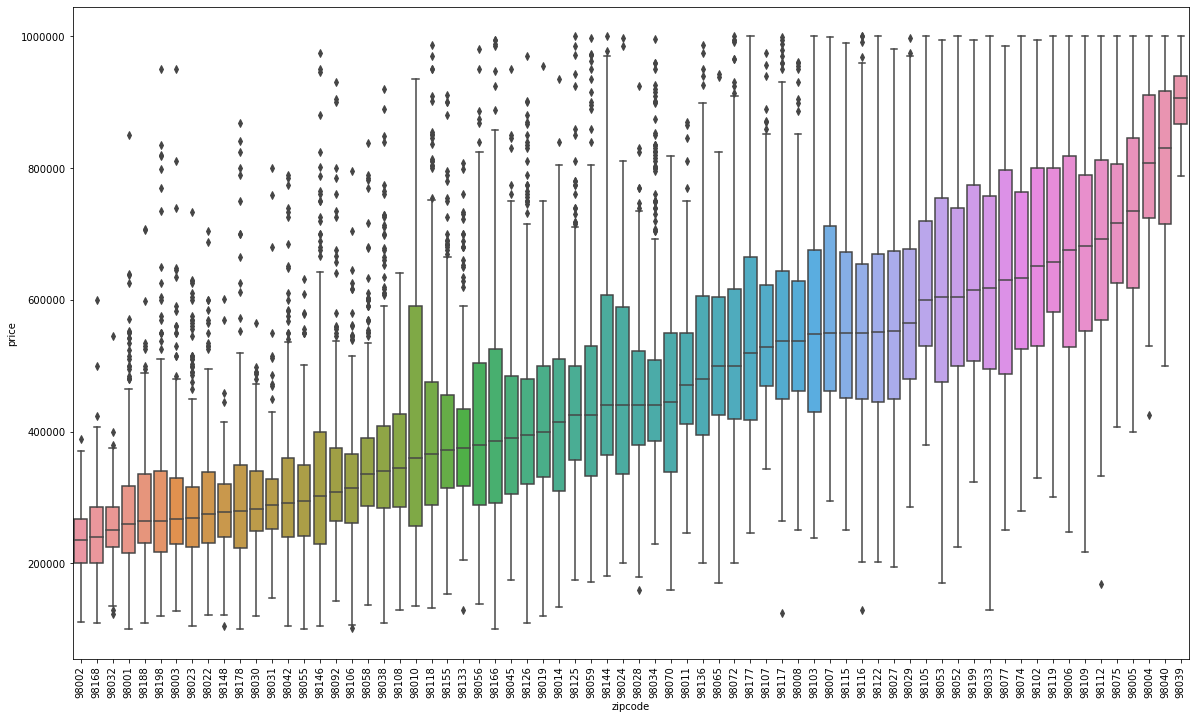

In [8]:
fig = plt.figure(figsize=(20, 12)) # define plot area
ax = fig.gca() # define axis 
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sorted_nb = housing.groupby(['zipcode'])['price'].median().sort_values()
sns.boxplot(x=housing['zipcode'], y=housing['price'], order=list(sorted_nb.index), ax=ax);

***Observations***

* Homesale prices are spread out evenly month over month with little variance. However, median prices are higher in April through July than the rest of the year.

* We observe an increase in the mean price as the number of bedrooms, bathrooms, condition or number of floors increase but questions
  about their significance will come later. 
* A strong relationship appears in the price vs grade plot. Higher grades command significantly higher prices. Also about every other
  interquantile range does not overlap.
* Waterfront properties sell for a higher price on average.
* Another strong relaitionship appears between price and zipcode. Some zipcodes command significantly higher prices. 

#### Continuous Variables

Now let's take a deeper look at our continuous variables. We saw from the distributional observations above that many of the numerical variables skewed right. We'll use a log transform to aid our discovery.

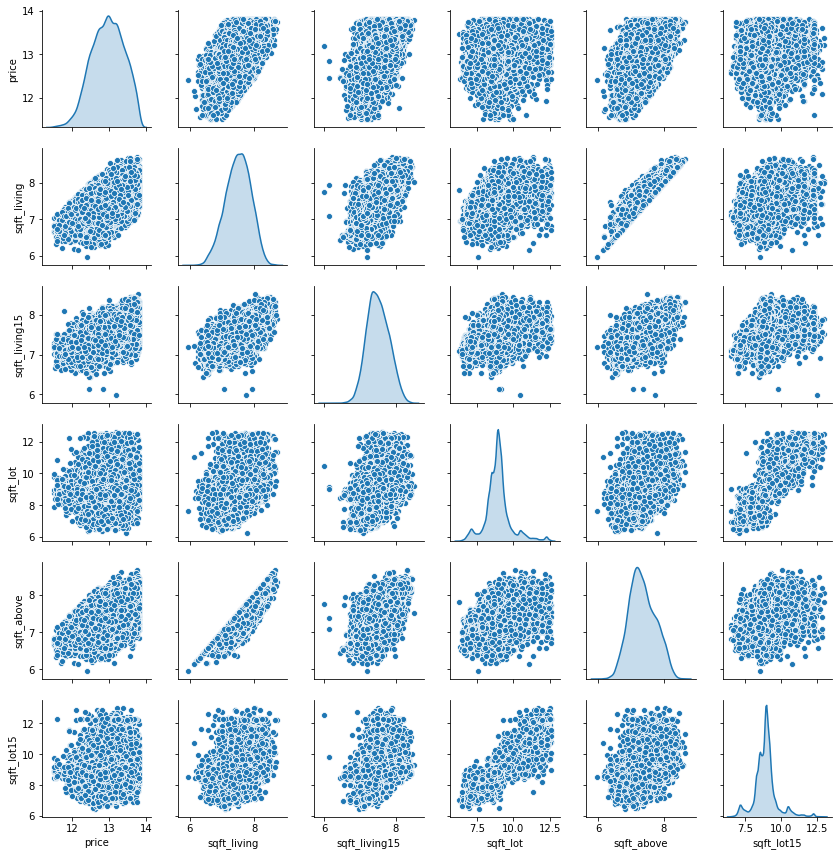

In [9]:
pair_plot_data = housing.loc[:,["price", "sqft_living","sqft_living15","sqft_lot",'sqft_above','sqft_lot15']]

pair_plot_data['price'] = np.log(pair_plot_data['price'])
pair_plot_data['sqft_living'] = np.log(pair_plot_data['sqft_living'])
pair_plot_data['sqft_living15'] = np.log(pair_plot_data['sqft_living15'])
pair_plot_data['sqft_lot'] = np.log(pair_plot_data['sqft_lot'])
pair_plot_data['sqft_above'] = np.log(pair_plot_data['sqft_above'])
pair_plot_data['sqft_lot15'] = np.log(pair_plot_data['sqft_lot15'])

#pair_plot_cols = ["price", "sqft_living", "sqft_lot",'sqft_above','sqft_basement','sqft_lot15'] 
sns.pairplot(pair_plot_data, palette="seismic", diag_kind="kde", height=2);

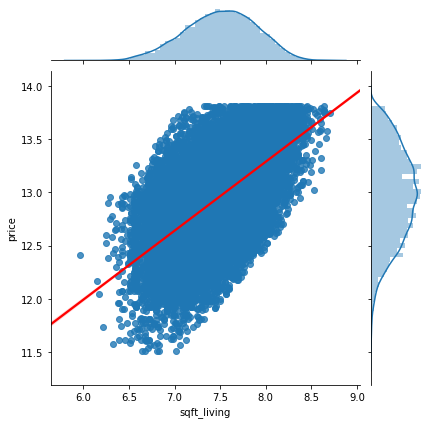

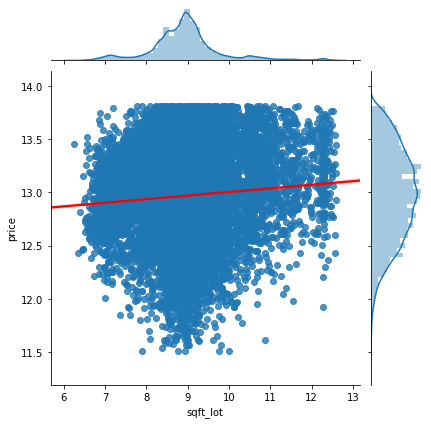

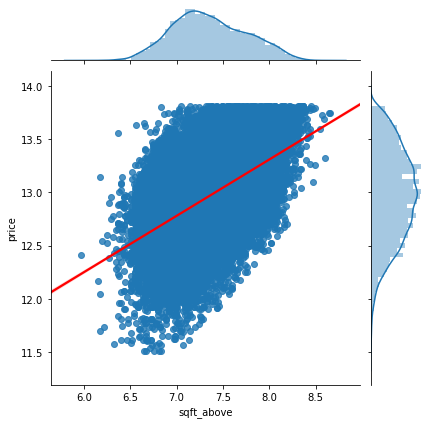

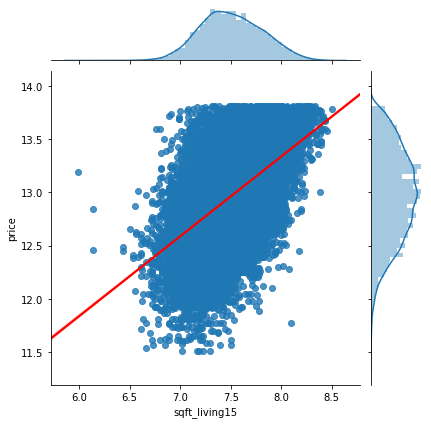

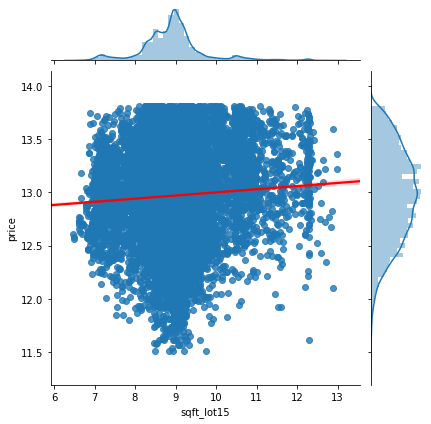

In [10]:
columns_for_hist = ['sqft_living','sqft_lot','sqft_above','sqft_living15','sqft_lot15']
for col in columns_for_hist:
      sns.jointplot(x=col, y="price",
                  data=pair_plot_data, 
                  kind='reg', 
                  label=col,
                  joint_kws={'line_kws':{'color':'red'}})

***Observations***
* I think the strongest observation to make here with respect to understanding price is that it increases with sqft_living. In addition it has a fairly normal distribution. 
* sqft_above and sqft_living have a moderate relationship with price

#### Understanding Price Along Multiple Dimensions

Now that we've identified strong relationships with price let's see how they relate among several dimensions

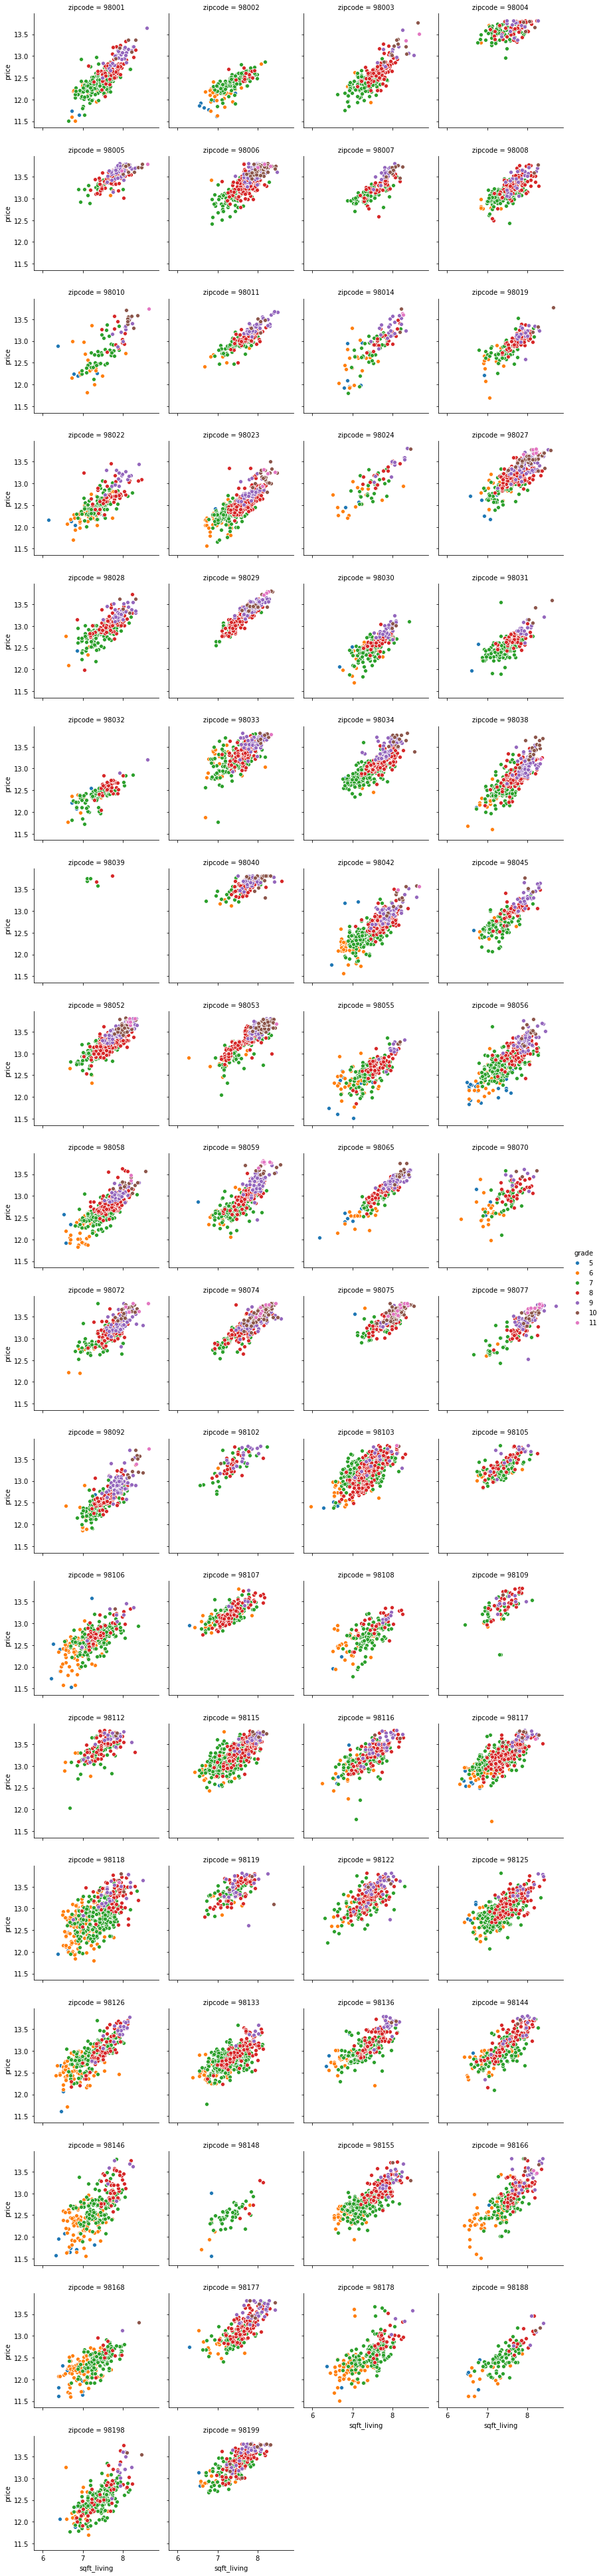

In [11]:
cond_plot_data = housing.loc[:,["price","zipcode","sqft_living","grade"]]
cond_plot_data['price'] = np.log(cond_plot_data['price'])
cond_plot_data['sqft_living'] = np.log(cond_plot_data['sqft_living'])

cond_plot = sns.FacetGrid(data=cond_plot_data, col='zipcode', hue='grade', col_wrap=4, legend_out=True, margin_titles=True)
cond_plot.map(sns.scatterplot, 'sqft_living', 'price');
cond_plot.add_legend();

**Observation**: The facet plot reveals clear linear relationships for price within each zipcode as both the sqft_living and grade increase.

*Note: 98039 doesn't have enough data points*

## Step 2: Identify a likely distribution for several of the features

In [12]:
# Setup code we'll use below
from scipy.stats import norm
from scipy import stats
from scipy.stats import kstest 
from sklearn.preprocessing import scale
import sklearn.preprocessing as sk


# Displays a histogram with it's theoretical pdf as well as a QQ-Plot, which we use
# for graphically evaluating the distributions of our features.
def qq_test(data, dist):
    plt.figure(figsize=(10, 6)).gca() 
    ax1 = plt.subplot(221) 
    res = stats.probplot(data, plot=ax1)
    ax2 = plt.subplot(222) 
    sns.distplot(data, fit=norm, bins=50, kde=False, ax=ax2);

def plot_cums(dist1, dist2):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)

    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p)
    plt.scatter(data_sorted, p, color = 'red')
    
    # sort the seond data sample:
    data_sorted = np.sort(dist2)
    
    # And the second plot
    plt.plot(data_sorted, p, color = 'yellow')
    plt.scatter(data_sorted, p, color = 'green')

#### Feature: sqft_living

We'll start off with a Q-Q Plot

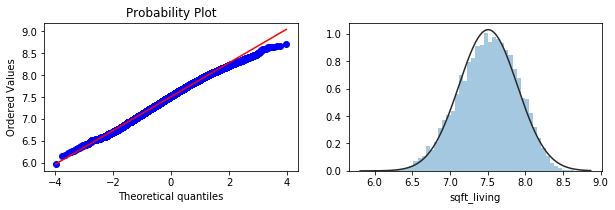

In [13]:
qq_test(np.log(housing['sqft_living']), norm)

As we can see in the plots sqft_living comes very close to a normal distribution. Now let's do a formal test in the form of the Kolmogorov-Smirnov Test.

Before performing the formal K-S test let's investigate the CDF's of the normalized sqft_living values and a theoretical standard normal since the test gives the maximum vertical distance between the respective CDF's. If visually they don't look quite close there would be no reason to bother with a formal test.

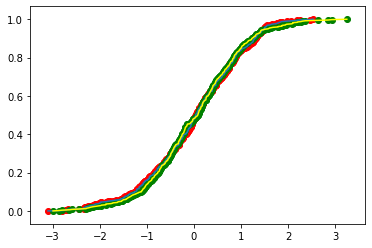

In [14]:
normalized_sqft_living = np.log(housing.sample(500).loc[:,"sqft_living"])
norm_dist = np.random.normal(size = 500).tolist()
plot_cums(sk.scale(normalized_sqft_living), norm_dist) 

Does it get any better?! Now let's move on to a formal test.

In [15]:
ks_statisic, pvalue = kstest(sk.scale(normalized_sqft_living), 'norm')
print('KS-statistic = ' + str(ks_statisic))
print('P-value = ' + str(pvalue));

KS-statistic = 0.03558821767614612
P-value = 0.550517505741753


**Conclusion**: The K-S statistic is small and the p-value is greater than our cutoff of .05. It appears that we cannot reject null hypothesis and conclude sqft_living was drawn from a normal distribution.

#### Feature: sqft_above

Again we'll start off with a Q-Q Plot

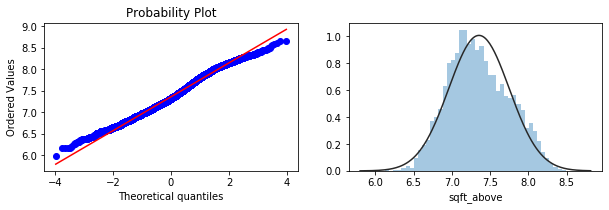

In [16]:
qq_test(np.log(housing['sqft_above']), norm)

As we can see in the plots sqft_above comes very close to a normal distribution. Now let's do a formal test in the form of the Kolmogorov-Smirnov Test.

Once again let's investigate the CDF's of the normalized sqft_above values and a theoretical standard normal.

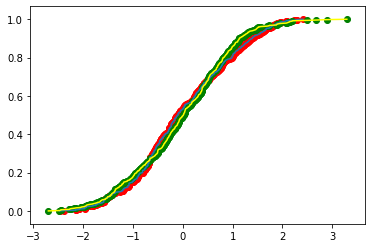

In [17]:
normalized_sqft_above = sk.scale(np.log(housing.sample(500).loc[:,"sqft_above"]))
norm_dist = np.random.normal(size = 500).tolist()
plot_cums(normalized_sqft_above, norm_dist) 

In [18]:
ks_statisic, pvalue = kstest(normalized_sqft_above, 'norm')
print('KS-statistic = ' + str(ks_statisic))
print('P-value = ' + str(pvalue));

KS-statistic = 0.04759470475341354
P-value = 0.20109311702556493


**Conclusion**: The K-S statistic is small and the p-value is greater than our cutoff of .05. It appears that we cannot reject null hypothesis and conclude sqft_above was drawn from a normal distribution.

#### Features: grade, condition, bathrooms, bedrooms, floors

These features are ordinal data, type of categorical variable, and so would lend themselves to their respective multinoulli distribution defined by their probability mass functions.

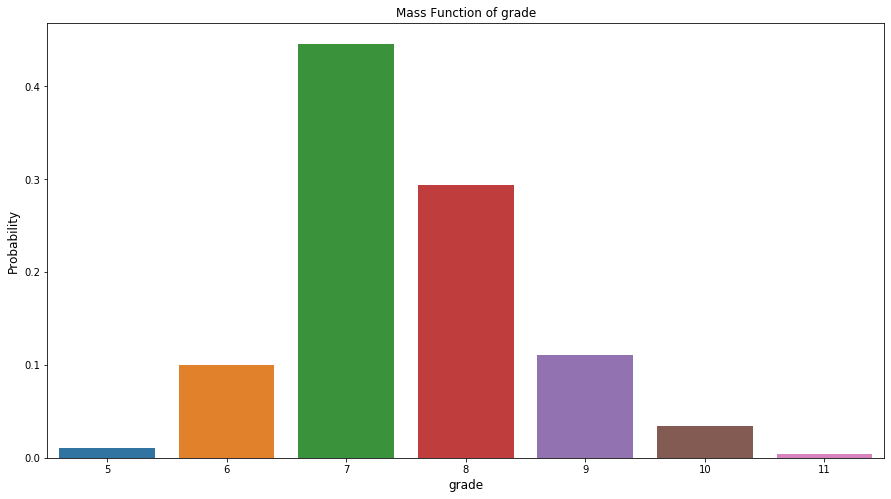

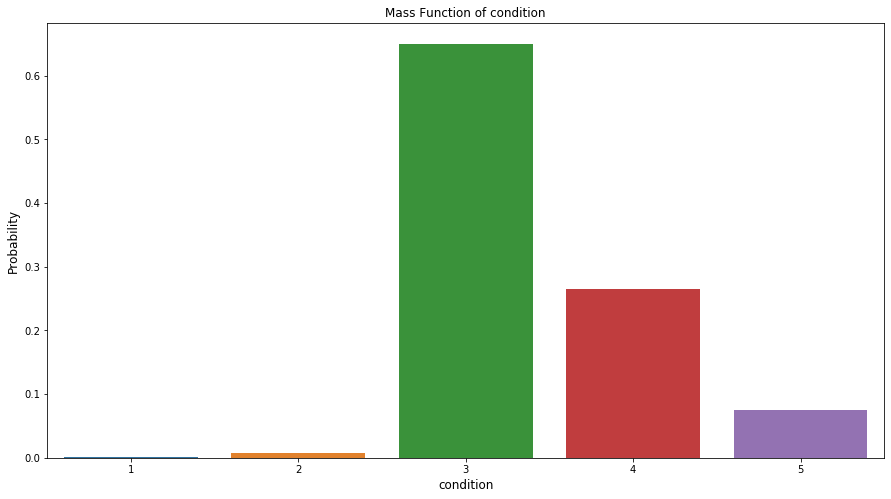

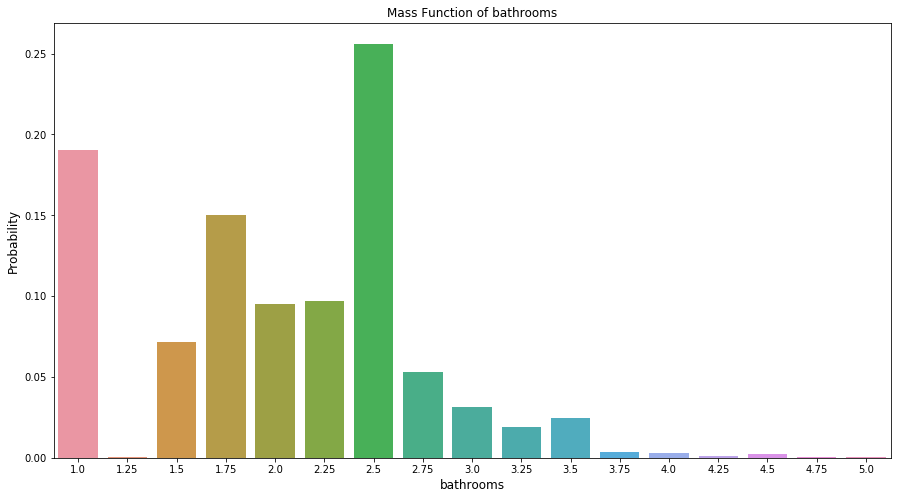

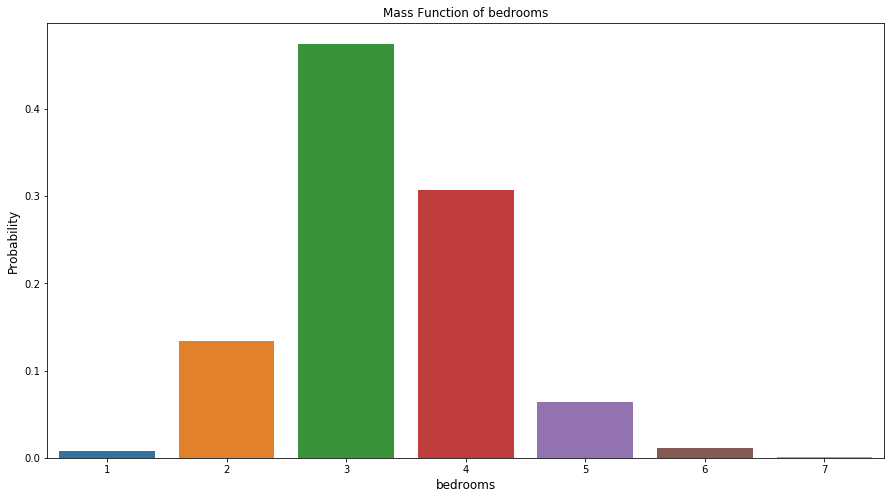

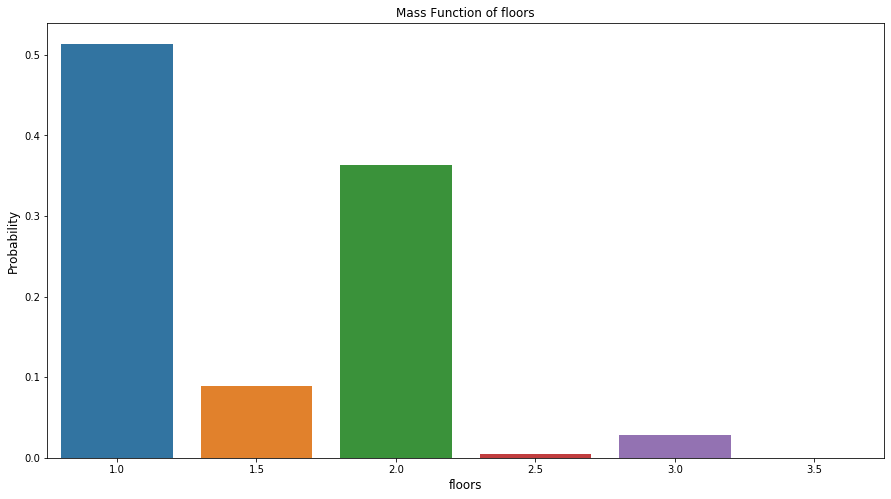

In [19]:
pmf_fields = ['grade','condition','bathrooms','bedrooms','floors']
for f in pmf_fields:
    plt.figure(figsize=(15,8))
    counts = housing[f].value_counts(normalize=True)    
    sns.barplot(counts.index, counts.values)
    plt.title(f'Mass Function of {f}')
    plt.ylabel('Probability', fontsize=12)
    plt.xlabel(f'{f}', fontsize=12)
    plt.show()

## Step 3 & 4: Compute some basic summary statistics and their confidence intervals by both classical, bootstrap, and Bayesian methods

The summary statistics below will be focused on fields I believe may have a chance at a relationship with price.

**NOTE**: The instructions are quite unclear, emails/questions aren't really answered and the material is lacking so I did my best and went off of this post. https://canvas.uw.edu/courses/1347202/discussion_topics/5101801 . 

#### Classical Summary Statistics

#### Feature: Grade

In [20]:
import math

cols_for_stats = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','view','condition','grade','sqft_above','sqft_basement','sqft_living15']

c_mean_price_by_grade = housing[['grade','price']].groupby('grade').agg(['mean', 'count', 'std'])
c_mean_price_by_grade['lower_ci'] = c_mean_price_by_grade.apply(lambda row: row[0] - 1.96*row[2]/math.sqrt(row[1]), axis=1)
c_mean_price_by_grade['upper_ci'] = c_mean_price_by_grade.apply(lambda row: row[0] + 1.96*row[2]/math.sqrt(row[1]), axis=1)
print(c_mean_price_by_grade)

               price                            lower_ci       upper_ci
                mean count            std                              
grade                                                                  
5      256204.423256   215  116692.172734  240606.076608  271802.769904
6      300915.271586  1992  115830.341921  295828.599488  306001.943685
7      399926.640625  8896  148903.813992  396832.325743  403020.955507
8      518686.834444  5853  167550.181713  514394.320521  522979.348367
9      670197.171118  2209  171067.290528  663063.301130  677331.041106
10     780307.173217   687  138587.755000  769943.766026  790670.580408
11     863035.897727    88  122111.502111  837522.323197  888549.472258


#### Feature: Floors

In [21]:
c_mean_price_by_floors = housing[['floors','price']].groupby('floors').agg(['mean', 'count', 'std'])
c_mean_price_by_floors['lower_ci'] = c_mean_price_by_floors.apply(lambda row: row[0] - 1.96*row[2]/math.sqrt(row[1]), axis=1)
c_mean_price_by_floors['upper_ci'] = c_mean_price_by_floors.apply(lambda row: row[0] + 1.96*row[2]/math.sqrt(row[1]), axis=1)
print(c_mean_price_by_floors)

                price                             lower_ci       upper_ci
                 mean  count            std                              
floors                                                                   
1.0     413220.688561  10246  175554.059259  409821.386391  416619.990731
1.5     508868.539023   1781  199478.078150  499604.096591  518132.981455
2.0     531773.588235   7242  200787.418649  527149.103955  536398.072516
2.5     625811.211538    104  185989.607316  590065.159835  661557.263242
3.0     501244.406417    561  159926.066343  488010.322143  514478.490691
3.5     511916.666667      6   46972.775803  474330.618043  549502.715290


#### Feature: Bedrooms

In [22]:
c_mean_price_by_bedrooms = housing[['bedrooms','price']].groupby('bedrooms').agg(['mean', 'count', 'std'])
c_mean_price_by_bedrooms['lower_ci'] = c_mean_price_by_bedrooms.apply(lambda row: row[0] - 1.96*row[2]/math.sqrt(row[1]), axis=1)
c_mean_price_by_bedrooms['upper_ci'] = c_mean_price_by_bedrooms.apply(lambda row: row[0] + 1.96*row[2]/math.sqrt(row[1]), axis=1)
print(c_mean_price_by_bedrooms)

                  price                            lower_ci       upper_ci
                   mean count            std                              
bedrooms                                                                  
1         330933.443038   158  134082.843346  310026.008827  351840.877249
2         392121.833896  2667  160277.836608  386038.830830  398204.836961
3         434829.821312  9469  179461.013760  431215.105742  438444.536882
4         532477.581319  6124  202900.565631  527395.732535  537559.430104
5         565927.993740  1278  206981.985048  554579.892748  577276.094733
6         572540.060185   216  205892.116609  545082.059341  599998.061030
7         618393.464286    28  210967.721899  540249.926533  696537.002039


#### Feature: Zipcode

In [23]:
c_mean_price_by_zipcode = housing[['zipcode','price']].groupby('zipcode').agg(['mean', 'count', 'std'])
c_mean_price_by_zipcode['lower_ci'] = c_mean_price_by_zipcode.apply(lambda row: row[0] - 1.96*row[2]/math.sqrt(row[1]), axis=1)
c_mean_price_by_zipcode['upper_ci'] = c_mean_price_by_zipcode.apply(lambda row: row[0] + 1.96*row[2]/math.sqrt(row[1]), axis=1)
print(c_mean_price_by_zipcode)

                 price                            lower_ci       upper_ci
                  mean count            std                              
zipcode                                                                  
98001    280967.633333   360   98880.515012  270753.170307  291182.096359
98002    234657.477157   197   51135.062607  227516.761328  241798.192986
98003    294111.278571   280  107597.662236  281508.105760  306714.451383
98004    806750.772059   136  124189.780330  785878.367875  827623.176242
98005    729714.958621   145  144546.820163  706187.196939  753242.720303
...                ...   ...            ...            ...            ...
98177    556902.841410   227  178617.936430  533666.475307  580139.207512
98178    303613.003891   257  127142.766583  288068.346053  319157.661729
98188    289701.518519   135  103233.199157  272287.116212  307115.920825
98198    296730.244526   274  129631.097901  281380.894521  312079.594530
98199    636363.317460   252  171233.0

#### Bootstrap Summary Statistics

In [24]:
# Uses below
def bootstrap_mean(data, field):
    means = []
    for _ in range(100):
        sample = data.sample(frac=1.0, replace=True)
        means.append(sample[field].mean())
    return means

def print_mean_and_ci(data, p=5):
    upper_ci = np.percentile(data, 100-p/2.)
    lower_ci = np.percentile(data, p/2.)
    print('Bootstrap mean: %6.2f' %(data.mean()))
    print('The lower and upper CI = %6.2f %6.2f \n' %(lower_ci,upper_ci))

#### Feature: Grade

In [25]:
grades = sorted(housing['grade'].unique())
for g in grades:
    print(f'Mean & CI of Price for Grade {g}')
    boot = pd.Series(bootstrap_mean(housing.loc[housing['grade'] == g], 'price'))
    print_mean_and_ci(boot,p=10)

Mean & CI of Price for Grade 5
Bootstrap mean: 256954.39
The lower and upper CI = 243870.33 270205.13 

Mean & CI of Price for Grade 6
Bootstrap mean: 300995.51
The lower and upper CI = 297038.93 304866.69 

Mean & CI of Price for Grade 7
Bootstrap mean: 399873.41
The lower and upper CI = 397235.94 401903.13 

Mean & CI of Price for Grade 8
Bootstrap mean: 518409.40
The lower and upper CI = 514868.17 521553.10 

Mean & CI of Price for Grade 9
Bootstrap mean: 669980.27
The lower and upper CI = 664211.43 675988.89 

Mean & CI of Price for Grade 10
Bootstrap mean: 779569.36
The lower and upper CI = 771553.87 787559.65 

Mean & CI of Price for Grade 11
Bootstrap mean: 863879.45
The lower and upper CI = 841030.06 886663.32 



#### Features: Floors

In [26]:
floors = sorted(housing['floors'].unique())
for f in floors:
    print(f'Mean & CI of Price for {f} story house')
    boot = pd.Series(bootstrap_mean(housing.loc[housing['floors'] == f], 'price'))
    print_mean_and_ci(boot,p=10)

Mean & CI of Price for 1.0 story house
Bootstrap mean: 413272.30
The lower and upper CI = 410589.36 416288.39 

Mean & CI of Price for 1.5 story house
Bootstrap mean: 508626.17
The lower and upper CI = 500831.17 515868.50 

Mean & CI of Price for 2.0 story house
Bootstrap mean: 531873.47
The lower and upper CI = 528145.69 535916.26 

Mean & CI of Price for 2.5 story house
Bootstrap mean: 627764.15
The lower and upper CI = 594869.50 659980.02 

Mean & CI of Price for 3.0 story house
Bootstrap mean: 501452.59
The lower and upper CI = 490269.50 512953.02 

Mean & CI of Price for 3.5 story house
Bootstrap mean: 516545.83
The lower and upper CI = 489425.00 539804.17 



#### Feature: Bedrooms

In [27]:
bedrooms = sorted(housing['bedrooms'].unique())
for b in bedrooms:
    print(f'Mean & CI of Price for {b}-bedroom house')
    boot = pd.Series(bootstrap_mean(housing.loc[housing['bedrooms'] == b], 'price'))
    print_mean_and_ci(boot,p=10)

Mean & CI of Price for 1-bedroom house
Bootstrap mean: 330481.26
The lower and upper CI = 313787.35 346105.33 

Mean & CI of Price for 2-bedroom house
Bootstrap mean: 392013.77
The lower and upper CI = 386286.22 396838.45 

Mean & CI of Price for 3-bedroom house
Bootstrap mean: 434798.07
The lower and upper CI = 432360.55 437980.17 

Mean & CI of Price for 4-bedroom house
Bootstrap mean: 532641.88
The lower and upper CI = 527749.29 537222.32 

Mean & CI of Price for 5-bedroom house
Bootstrap mean: 565300.16
The lower and upper CI = 556175.11 574369.25 

Mean & CI of Price for 6-bedroom house
Bootstrap mean: 573127.29
The lower and upper CI = 550724.22 597140.54 

Mean & CI of Price for 7-bedroom house
Bootstrap mean: 620075.48
The lower and upper CI = 569863.23 691410.87 



#### Feature: Zipcode

In [28]:
zipcodes = sorted(housing['zipcode'].unique())
for z in zipcodes:
    print(f'Mean & CI of Price for a house in zipcode {z}')
    boot = pd.Series(bootstrap_mean(housing.loc[housing['zipcode'] == z], 'price'))
    print_mean_and_ci(boot,p=10)

Mean & CI of Price for a house in zipcode 98001
Bootstrap mean: 280419.50
The lower and upper CI = 268966.77 289484.66 

Mean & CI of Price for a house in zipcode 98002
Bootstrap mean: 234455.03
The lower and upper CI = 228313.19 240557.17 

Mean & CI of Price for a house in zipcode 98003
Bootstrap mean: 294189.76
The lower and upper CI = 282502.41 304651.01 

Mean & CI of Price for a house in zipcode 98004
Bootstrap mean: 805171.45
The lower and upper CI = 784220.25 822519.86 

Mean & CI of Price for a house in zipcode 98005
Bootstrap mean: 729372.13
The lower and upper CI = 714812.73 749607.34 

Mean & CI of Price for a house in zipcode 98006
Bootstrap mean: 673711.19
The lower and upper CI = 659439.01 687152.69 

Mean & CI of Price for a house in zipcode 98007
Bootstrap mean: 590354.75
The lower and upper CI = 571937.77 607469.24 

Mean & CI of Price for a house in zipcode 98008
Bootstrap mean: 558678.90
The lower and upper CI = 546431.61 571820.55 

Mean & CI of Price for a house i

#### Baysian Summary Statistics

In [29]:
from scipy.stats import bayes_mvs

#### Feature: Grade

In [30]:
grades = sorted(housing['grade'].unique())
for g in grades:
    print(f'Mean & CI of Price for Grade {g}')
    # Uses Jeffrey’s prior
    price_for_grade = housing.loc[housing['grade'] == g]
    stats = bayes_mvs(price_for_grade['price'], .95)
    print(f'Mean: {stats[0][0]}, HDI: {stats[0][1][0]} - {stats[0][1][1]}')
    print('\n')

Mean & CI of Price for Grade 5
Mean: 256204.42325581395, HDI: 240517.64944014483 - 271891.19707148307


Mean & CI of Price for Grade 6
Mean: 300915.2715863454, HDI: 295829.9698686663 - 306000.57330402447


Mean & CI of Price for Grade 7
Mean: 399926.640625, HDI: 396832.5565194533 - 403020.7247305467


Mean & CI of Price for Grade 8
Mean: 518686.83444387495, HDI: 514394.76609939436 - 522978.90278835554


Mean & CI of Price for Grade 9
Mean: 670197.171118153, HDI: 663065.0470981926 - 677329.2951381134


Mean & CI of Price for Grade 10
Mean: 780307.173216885, HDI: 769925.6400484184 - 790688.7063853515


Mean & CI of Price for Grade 11
Mean: 863035.8977272727, HDI: 837162.9426117067 - 888908.8528428387




#### Feature: Floors

In [31]:
floors = sorted(housing['floors'].unique())
for f in floors:
    print(f'Mean & CI of Price for {f}-story house')
    # Uses Jeffrey’s prior
    price_for_floors = housing.loc[housing['floors'] == f]
    stats = bayes_mvs(price_for_floors['price'], .95)
    print(f'Mean: {stats[0][0]}, HDI: {stats[0][1][0]} - {stats[0][1][1]}')
    print('\n')

Mean & CI of Price for 1.0-story house
Mean: 413220.6885613898, HDI: 409821.61473974044 - 416619.76238303917


Mean & CI of Price for 1.5-story house
Mean: 508868.53902302077, HDI: 499606.8680546837 - 518130.2099913578


Mean & CI of Price for 2.0-story house
Mean: 531773.5882352941, HDI: 527149.5082182992 - 536397.668252289


Mean & CI of Price for 2.5-story house
Mean: 625811.2115384615, HDI: 589640.8734475242 - 661981.5496293989


Mean & CI of Price for 3.0-story house
Mean: 501244.4064171123, HDI: 487981.9012850834 - 514506.91154914116


Mean & CI of Price for 3.5-story house
Mean: 511916.6666666667, HDI: 462621.7616150818 - 561211.5717182516




#### Feature: Bedrooms

In [32]:
bedrooms = sorted(housing['bedrooms'].unique())
for b in bedrooms:
    print(f'Mean & CI of Price for {b}-bedroom house')
    # Uses Jeffrey’s prior
    price_for_bedrooms = housing.loc[housing['bedrooms'] == b]
    stats = bayes_mvs(price_for_bedrooms['price'], .95)
    print(f'Mean: {stats[0][0]}, HDI: {stats[0][1][0]} - {stats[0][1][1]}')
    print('\n')

Mean & CI of Price for 1-bedroom house
Mean: 330933.4430379747, HDI: 309863.9851398958 - 352002.9009360536


Mean & CI of Price for 2-bedroom house
Mean: 392121.83389576303, HDI: 386040.0831135648 - 398203.58467796125


Mean & CI of Price for 3-bedroom house
Mean: 434829.8213116485, HDI: 431215.36303534324 - 438444.2795879538


Mean & CI of Price for 4-bedroom house
Mean: 532477.5813193991, HDI: 527396.2408365308 - 537558.9218022673


Mean & CI of Price for 5-bedroom house
Mean: 565927.993740219, HDI: 554584.5418480276 - 577271.4456324105


Mean & CI of Price for 6-bedroom house
Mean: 572540.0601851852, HDI: 544927.1300628042 - 600152.9903075661


Mean & CI of Price for 7-bedroom house
Mean: 618393.4642857143, HDI: 536588.7217206549 - 700198.2068507738




In [33]:
zipcodes = sorted(housing['zipcode'].unique())
for z in zipcodes:
    print(f'Mean & CI of Price for house in {z}')
    # Uses Jeffrey’s prior
    price_for_zipcodes = housing.loc[housing['zipcode'] == z]
    stats = bayes_mvs(price_for_zipcodes['price'], .95)
    print(f'Mean: {stats[0][0]}, HDI: {stats[0][1][0]} - {stats[0][1][1]}')
    print('\n')

Mean & CI of Price for house in 98001
Mean: 280967.63333333336, HDI: 270718.8062597814 - 291216.4604068853


Mean & CI of Price for house in 98002
Mean: 234657.4771573604, HDI: 227472.52815824398 - 241842.42615647684


Mean & CI of Price for house in 98003
Mean: 294111.27857142856, HDI: 281453.42903858644 - 306769.12810427067


Mean & CI of Price for house in 98004
Mean: 806750.7720588235, HDI: 785689.9595278235 - 827811.5845898235


Mean & CI of Price for house in 98005
Mean: 729714.9586206897, HDI: 705988.2305109771 - 753441.6867304023


Mean & CI of Price for house in 98006
Mean: 674899.7368421053, HDI: 656880.3097193162 - 692919.1639648944


Mean & CI of Price for house in 98007
Mean: 588528.4850746269, HDI: 561457.084591702 - 615599.8855575518


Mean & CI of Price for house in 98008
Mean: 556222.6818181818, HDI: 539893.9180886616 - 572551.4455477019


Mean & CI of Price for house in 98010
Mean: 422439.1649484536, HDI: 382717.20197775034 - 462161.12791915686


Mean & CI of Price fo

## Step 5: Leverage confidence intervals in performing hypothesis tests to determine if the differences in pairs and multiple populations are significant.

**NOTE**: We barely touched the topic of confidence intervals let alone how they relate to hypothesis testing. On top of the fact that Stephen had to post the calculation an an aside here https://canvas.uw.edu/courses/1347202/discussion_topics/5226810 this reflects how poorly we covered the topic. This is my best shot I suppose. 

#### Feature: Grade, Floors, Bedrooms

We can see from the CI intervals above in each of the features that the CI's overlap for most of the groups with each feature so the prices were NOT drawn from the same distribution. Meaning there is a significant difference in the mean price between the groups within each feature.

Because the work above didn't have any code I decided to add this ANOVA test for grade.

In [34]:
#imports for this section
import scipy.stats as ss
import statsmodels.stats.weightstats as ws
import sklearn.preprocessing as sk

We're interested in understanding the significance of grade with repspect to price.

**Null Hypothesis**: There is not significant difference in the mean price among all the grades

**Alternative Hypothesis**: At least one grade has a statistically different mean price.

In [35]:
g_five = housing.loc[housing['grade'] == 5]
g_six = housing.loc[housing['grade'] == 6]
g_seven = housing.loc[housing['grade'] == 7]
g_eight = housing.loc[housing['grade'] == 8]
g_nine = housing.loc[housing['grade'] == 9]
g_ten = housing.loc[housing['grade'] == 10]
g_eleven = housing.loc[housing['grade'] == 11]

f_statistic, p_value = ss.f_oneway(
    np.log10(g_five.loc[:,'price']), 
    np.log10(g_six.loc[:,'price']), 
    np.log10(g_seven.loc[:,'price']), 
    np.log10(g_eight.loc[:,'price']), 
    np.log10(g_nine.loc[:,'price']),
    np.log10(g_ten.loc[:,'price']),
    np.log10(g_eleven.loc[:,'price']))

print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 1930.0954238345525
P-value = 0.0


The F-Statistic is fairly large and the p-value is 0. We can reject the null hypothesis that houses of the different grades have the same mean price. At least one grade has a statistically different mean price.

## Generate and Evaluate a Working Linear Model

In [36]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Scale function
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

def plot_resid_dist(resids):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    sns.distplot(resids, bins=20, ax=ax[0])
    ax[0].set_title('Histogram of residuals')
    ax[0].set_xlabel('Residual values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of residuals')
    plt.show()
    
def residual_plot(df):
    RMSE = np.std(df.resids)
    sns.scatterplot(x='predicted', y='resids', data=df)
    plt.axhline(0.0, color='red', linewidth=1.0)
    plt.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.title('PLot of residuals vs. predicted')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()

def set_D(s, cutoff=0.01):
    '''Function creates inverse singular value matrix for 
    singular values greater than cutoff * largest singular value.'''
    d = []
    for sv in s:
        if(sv > cutoff * s[0]): d.append(1.0/sv)
        else: d.append(0.0)
    return np.diag(d)

#### Prepare Data

From our exploration above sqft_living, grade, zipcode, bedrooms, batrhooms, condition and yr_built is what we will begin our linear model with as features of price. 

In [37]:
lm_model_data = pd.DataFrame({
    "price": scale(np.log(housing.loc[:,"price"])),
    "sqft_living": scale(np.log(housing.loc[:,"sqft_living"])),
    "grade": housing.grade.astype('category'),
    "zipcode": housing.zipcode.astype('category'),
    "bedrooms": housing.bedrooms.astype('category'),
    "bathrooms": housing.bathrooms.astype('category'),
    "condition": housing.condition.astype('category'),
})

#### Execute Our Model

In [38]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

ols_model = smf.ols(formula = 'price ~ sqft_living + C(grade) + C(zipcode) + C(bedrooms) + C(bathrooms) + C(condition)', data=lm_model_data).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     884.7
Date:                Sat, 14 Mar 2020   Prob (F-statistic):               0.00
Time:                        06:57:25   Log-Likelihood:                -11209.
No. Observations:               19940   AIC:                         2.262e+04
Df Residuals:                   19837   BIC:                         2.344e+04
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.7297      0.098    -17.690      0.000      -1.921      -1.538
C(grade)[T.6]            0.0938      0.031      3.010      0.003       0.033       0.155
C(grade)[T.7]            0.2835      0.031      9.156      0.000       0.223       0.344
C(grade)[T.8]            0.5120      0.032     15.934      0.000       0.449       0.575
C(grade)[T.9]            0.8207      0.034     24.240      0.000       0.754       0.887
C(grade)[T.10]           0.9640      0.038     25.700      0.000       0.890       1.038
C(grade)[T.11]           1.1738      0.057     20.482      0.000       1.061       1.286
C(zipcode)[T.98002]     -0.0954      0.038     -2.517      0.012      -0.170      -0.021
C(zipcode)[T.98003]      0.0516      0.034      1.518      0.129      -0.015       0.118
C(zipcode)[T.98004]      2.4142      0.043     56.169      0.000       2.330       2.498
C(zipcode)[T.98005]      1.7372      0.042     41.198      0.000       1.655       1.820
C(zipcode)[T.98006]      1.5063      0.032     47.520      0.000       1.444       1.568
C(zipcode)[T.98007]      1.5094      0.043     34.856      0.000       1.425       1.594
C(zipcode)[T.98008]      1.5188      0.035     43.818      0.000       1.451       1.587
C(zipcode)[T.98010]      0.6510      0.049     13.345      0.000       0.555       0.747
C(zipcode)[T.98011]      1.0552      0.038     27.768      0.000       0.981       1.130
C(zipcode)[T.98014]      0.7954      0.046     17.168      0.000       0.705       0.886
C(zipcode)[T.98019]      0.8061      0.039     20.815      0.000       0.730       0.882
C(zipcode)[T.98022]      0.2108      0.037      5.713      0.000       0.138       0.283
C(zipcode)[T.98023]     -0.0592      0.030     -1.998      0.046      -0.117      -0.001
C(zipcode)[T.98024]      1.1217      0.056     20.018      0.000       1.012       1.231
C(zipcode)[T.98027]      1.2245      0.031     38.965      0.000       1.163       1.286
C(zipcode)[T.98028]      0.9767      0.034     28.713      0.000       0.910       1.043
C(zipcode)[T.98029]      1.3507      0.033     40.499      0.000       1.285       1.416
C(zipcode)[T.98030]      0.1098      0.035      3.152      0.002       0.042       0.178
C(zipcode)[T.98031]      0.1579      0.034      4.611      0.000       0.091       0.225
C(zipcode)[T.98032]     -0.0698      0.045     -1.556      0.120      -0.158       0.018
C(zipcode)[T.98033]      1.7409      0.032     54.016      0.000       1.678       1.804
C(zipcode)[T.98034]      1.2227      0.029     41.791      0.000       1.165       1.280
C(zipcode)[T.98038]      0.4112      0.029     14.350      0.000       0.355       0.467
C(zipcode)[T.98039]      2.9946      0.175     17.081      0.000       2.651       3.338
C(zipcode)[T.98040]      2.0385      0.042     48.457    

#### Evaluating Our First Model

**Conclusions From Above:**
   1. The adjusted R^2 statistic isn't terrible at .819. Suggesting an ok mode fit.
   2. For most of coeffients p-value is small and the confidence interval does not include zero. These coefficients are statistically significant. 
   3. The large F-statistic and small p-value indicate that we can reject null hypothesis and say the model is significant in terms of explaining the data.


**Analysis of Residuals**

In [39]:
lm_model_data['predicted'] = ols_model.predict()
lm_model_data['resids'] = np.subtract(lm_model_data.predicted, lm_model_data.price)
lm_model_data.head()

,price,sqft_living,grade,zipcode,bedrooms,bathrooms,condition,predicted,resids
0,-1.530760,-1.119381,7,98178,3,1.00,3,-1.300009,0.230751
1,0.529362,0.892213,7,98125,3,2.25,3,0.431129,-0.098233
2,-2.017556,-2.222563,6,98028,2,1.00,3,-1.332694,0.684862
3,0.798535,0.191968,7,98136,4,3.00,5,0.688855,-0.109680
4,0.405034,-0.206403,8,98074,3,2.00,3,0.232454,-0.172580


The mean of the residuals = 0.000
RMSE = 0.425





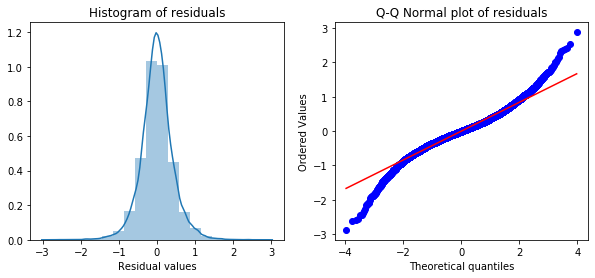

In [40]:
print('The mean of the residuals = %4.3f' % (np.mean(lm_model_data.resids)))
print('RMSE = %4.3f' % (np.std(lm_model_data.resids)))
print('\n\n')
plot_resid_dist(lm_model_data.resids)

**Conclusion**: The mean of the residuals is zero, the RSME is low and the distribution is normal right in the middle, but has skews at the ends. We can do better and hopefully will improve this in our other models.

##### Understanding Homoscedasticity

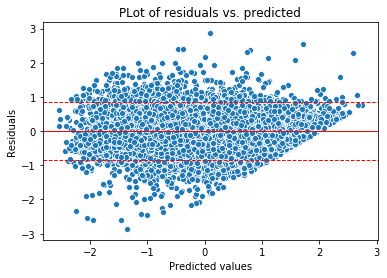

In [41]:
residual_plot(lm_model_data)  

**Conclusion**: Again the outcome is not ideal. However the redsiduals are reasonably homoscedastic for x < 0, but heteroscedastic for x > 0. Additionally there are a number of outliers. Perhaps we can improve that in the later models.

## Alternative Model 1: Reduce Modeal Params

Here we will tinker with getting the fewest number of features that peform just as well. We want the simplest model that explains the most possible.

In [42]:
lm_model_data_2 = pd.DataFrame({
    "price": scale(np.log(housing.loc[:,"price"])),
    "sqft_living": scale(np.log(housing.loc[:,"sqft_living"])),
    "grade": housing.grade.astype('category'),
    "zipcode": housing.zipcode.astype('category'),
    "condition": housing.condition.astype('category')
})



ols_model_2 = smf.ols(formula = 'price ~ sqft_living + C(grade) + C(zipcode) + C(condition)', data=lm_model_data_2).fit()
ols_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     1116.
Date:                Sat, 14 Mar 2020   Prob (F-statistic):               0.00
Time:                        06:57:30   Log-Likelihood:                -11307.
No. Observations:               19940   AIC:                         2.278e+04
Df Residuals:                   19859   BIC:                         2.342e+04
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.8904      0.093    -20.244      0.000      -2.073      -1.707
C(grade)[T.6]           0.0800      0.031      2.569      0.010       0.019       0.141
C(grade)[T.7]           0.2460      0.031      8.037      0.000       0.186       0.306
C(grade)[T.8]           0.4811      0.032     15.195      0.000       0.419       0.543
C(grade)[T.9]           0.8091      0.033     24.163      0.000       0.743       0.875
C(grade)[T.10]          0.9712      0.037     26.175      0.000       0.898       1.044
C(grade)[T.11]          1.1972      0.057     21.001      0.000       1.085       1.309
C(zipcode)[T.98002]    -0.1009      0.038     -2.655      0.008      -0.175      -0.026
C(zipcode)[T.98003]     0.0506      0.034      1.482      0.138      -0.016       0.117
C(zipcode)[T.98004]     2.4133      0.043     55.996      0.000       2.329       2.498
C(zipcode)[T.98005]     1.7319      0.042     40.963      0.000       1.649       1.815
C(zipcode)[T.98006]     1.5029      0.032     47.284      0.000       1.441       1.565
C(zipcode)[T.98007]     1.4818      0.043     34.166      0.000       1.397       1.567
C(zipcode)[T.98008]     1.5042      0.035     43.315      0.000       1.436       1.572
C(zipcode)[T.98010]     0.6563      0.049     13.401      0.000       0.560       0.752
C(zipcode)[T.98011]     1.0523      0.038     27.601      0.000       0.978       1.127
C(zipcode)[T.98014]     0.8081      0.046     17.395      0.000       0.717       0.899
C(zipcode)[T.98019]     0.8122      0.039     20.899      0.000       0.736       0.888
C(zipcode)[T.98022]     0.2106      0.037      5.691      0.000       0.138       0.283
C(zipcode)[T.98023]    -0.0627      0.030     -2.111      0.035      -0.121      -0.004
C(zipcode)[T.98024]     1.1246      0.056     20.007      0.000       1.014       1.235
C(zipcode)[T.98027]     1.2273      0.031     38.993      0.000       1.166       1.289
C(zipcode)[T.98028]     0.9788      0.034     28.682      0.000       0.912       1.046
C(zipcode)[T.98029]     1.3523      0.033     40.439      0.000       1.287       1.418
C(zipcode)[T.98030]     0.1063      0.035      3.042      0.002       0.038       0.175
C(zipcode)[T.98031]     0.1539      0.034      4.476      0.000       0.086       0.221
C(zipcode)[T.98032]    -0.0759      0.045     -1.687      0.092      -0.164       0.012
C(zipcode)[T.98033]     1.7407      0.032     53.808      0.000       1.677       1.804
C(zipcode)[T.98034]     1.2185      0.029     41.528      0.000       1.161       1.276
C(zipcode)[T.98038]     0.4135      0.029     14.398      0.000       0.357       0.470
C(zipcode)[T.98039]     2.9927      0.176     17.001      0.000       2.648       3.338
C(zipcode)[T.98040]     2.0254      0.042     48.061      0.000       1.943       2.108
C(z

In [43]:
lm_model_data_2['predicted'] = ols_model_2.predict()
lm_model_data_2['resids'] = np.subtract(lm_model_data_2.predicted, lm_model_data_2.price)
lm_model_data_2.head()

,price,sqft_living,grade,zipcode,condition,predicted,resids
0,-1.530760,-1.119381,7,98178,3,-1.315763,0.214998
1,0.529362,0.892213,7,98125,3,0.439225,-0.090137
2,-2.017556,-2.222563,6,98028,3,-1.358422,0.659134
3,0.798535,0.191968,7,98136,5,0.682815,-0.115721
4,0.405034,-0.206403,8,98074,3,0.251149,-0.153885


The mean of the residuals = 0.000
RMSE = 0.427





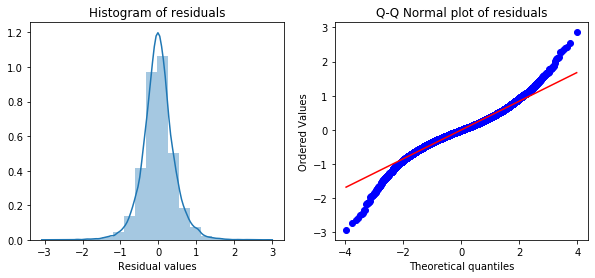

In [44]:
print('The mean of the residuals = %4.3f' % (np.mean(lm_model_data_2.resids)))
print('RMSE = %4.3f' % (np.std(lm_model_data_2.resids)))
print('\n\n')
plot_resid_dist(lm_model_data_2.resids)

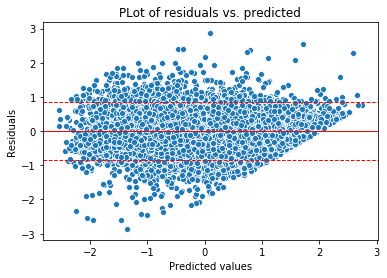

In [45]:
residual_plot(lm_model_data)  

**Conclusion**: Our analysis from above holds for this model as well, but it's better because we're getting the same results with fewer features.

## Alternative Model 2: Adding Yr Built Using QR and Pasty

#### Create Model

In [46]:
from patsy import dmatrices
from statsmodels.regression.linear_model import OLS


qr_data = pd.DataFrame({
    "price": scale(np.log(housing.loc[:,"price"])),
    "sqft_living": scale(np.log(housing.loc[:,"sqft_living"])),
    "grade": housing.grade.astype('category'),
    "zipcode": housing.zipcode.astype('category'),
    "condition": housing.condition.astype('category'),
    "yr_built": housing.yr_built.astype('category')
})

svd_target, svd_features = dmatrices('price ~ sqft_living + C(grade) + C(zipcode) + C(condition) + C(yr_built)', data=qr_data)

reg_model = OLS(svd_target, svd_features).fit(method='qr') 
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     481.9
Date:                Sat, 14 Mar 2020   Prob (F-statistic):               0.00
Time:                        06:57:34   Log-Likelihood:                -10837.
No. Observations:               19940   AIC:                         2.207e+04
Df Residuals:                   19744   BIC:                         2.362e+04
Df Model:                         195                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.8133      0.102    -17.778      0.000      -2.013      -1.613
C(grade)[T.6]           0.1518      0.031      4.913      0.000       0.091       0.212
C(grade)[T.7]           0.4022      0.031     12.965      0.000       0.341       0.463
C(grade)[T.8]           0.6722      0.032     20.730      0.000       0.609       0.736
C(grade)[T.9]           0.9912      0.034     28.907      0.000       0.924       1.058
C(grade)[T.10]          1.1509      0.038     30.421      0.000       1.077       1.225
C(grade)[T.11]          1.3714      0.057     24.106      0.000       1.260       1.483
C(zipcode)[T.98002]    -0.1163      0.037     -3.108      0.002      -0.190      -0.043
C(zipcode)[T.98003]     0.0535      0.034      1.595      0.111      -0.012       0.119
C(zipcode)[T.98004]     2.3661      0.043     55.084      0.000       2.282       2.450
C(zipcode)[T.98005]     1.7501      0.042     41.838      0.000       1.668       1.832
C(zipcode)[T.98006]     1.5017      0.031     47.790      0.000       1.440       1.563
C(zipcode)[T.98007]     1.4962      0.043     34.875      0.000       1.412       1.580
C(zipcode)[T.98008]     1.5360      0.035     44.377      0.000       1.468       1.604
C(zipcode)[T.98010]     0.6577      0.048     13.631      0.000       0.563       0.752
C(zipcode)[T.98011]     1.0499      0.037     28.009      0.000       0.976       1.123
C(zipcode)[T.98014]     0.8046      0.046     17.592      0.000       0.715       0.894
C(zipcode)[T.98019]     0.7987      0.038     20.851      0.000       0.724       0.874
C(zipcode)[T.98022]     0.1760      0.037      4.818      0.000       0.104       0.248
C(zipcode)[T.98023]    -0.0408      0.029     -1.394      0.163      -0.098       0.017
C(zipcode)[T.98024]     1.0973      0.055     19.834      0.000       0.989       1.206
C(zipcode)[T.98027]     1.2305      0.031     39.749      0.000       1.170       1.291
C(zipcode)[T.98028]     0.9641      0.034     28.694      0.000       0.898       1.030
C(zipcode)[T.98029]     1.3326      0.033     40.251      0.000       1.268       1.398
C(zipcode)[T.98030]     0.0902      0.034      2.621      0.009       0.023       0.158
C(zipcode)[T.98031]     0.1610      0.034      4.751      0.000       0.095       0.227
C(zipcode)[T.98032]    -0.0590      0.044     -1.331      0.183      -0.146       0.028
C(zipcode)[T.98033]     1.7282      0.032     54.275      0.000       1.666       1.791
C(zipcode)[T.98034]     1.2417      0.029     42.718      0.000       1.185       1.299
C(zipcode)[T.98038]     0.4053      0.028     14.244      0.000       0.350       0.461
C(zipcode)[T.98039]     2.9793      0.173     17.197      0.000       2.640       3.319
C(zipcode)[T.98040]     2.0254      0.042     48.546      0.000       1.944       2.107
C(z

In [47]:
qr_data['predicted'] = reg_model.predict()
qr_data['resids'] = np.subtract(qr_data.predicted, qr_data.price)
qr_data.head()

,price,sqft_living,grade,zipcode,condition,yr_built,predicted,resids
0,-1.530760,-1.119381,7,98178,3,1955,-1.346895,0.183865
1,0.529362,0.892213,7,98125,3,1951,0.485236,-0.044127
2,-2.017556,-2.222563,6,98028,3,1933,-1.143137,0.874419
3,0.798535,0.191968,7,98136,5,1965,0.474311,-0.324224
4,0.405034,-0.206403,8,98074,3,1987,0.238740,-0.166294


The mean of the residuals = -0.000
RMSE = 0.417





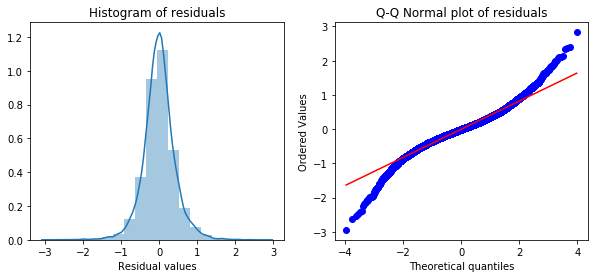

In [48]:
print('The mean of the residuals = %4.3f' % (np.mean(qr_data.resids)))
print('RMSE = %4.3f' % (np.std(qr_data.resids)))
print('\n\n')
plot_resid_dist(qr_data.resids)

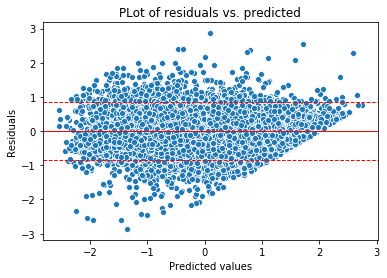

In [49]:
residual_plot(lm_model_data)  

**Conclusion**: We improved the adjusted R^2 of our model to .825, which isn't too bad. The evaluation from the above models still holds.